## Install Required Packages
Run this cell first to install all necessary packages if not already installed.

In [1]:
# Install required packages
# %pip install pandas cvss

### Evaluation Notebook for LLM Responses

This notebook contains scripts to evaluate the properly formatted responses from large language models (LLMs) for four tasks:

- **CTI-MCQ Task**: The response should be a letter corresponding to the correct answer (A, B, C, D or X which indicates error, such as refusing to answer).
- **CTI-RCM and CTI-RCM-2021 Tasks**: The response should be a properly formatted CWE ID.
- **CTI-VSP Task**: The response should be a properly formatted CVSS v3 string.
- **CTI-TAA Task**: The response should be the name of the threat actor.

Check the files in the `responses` folder for examples. This notebook will evaluate the responses from the ChatGPT-4 model and calculate the evaluation metrics.

Libraries required
- pandas
- cvss (https://pypi.org/project/cvss/)

In [2]:
import pandas as pd
from cvss import CVSS3
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [3]:
model_name = 'llama-local-instruct'  # corresponds to the column name in the respone sheet

### CTI-VSP evaluation

In [4]:
def get_cvss_score(cvss_vector):
    c = CVSS3(cvss_vector)
    cvss_score = c.scores()[0]
    return cvss_score

In [5]:
def compute_vsp_mad(fname, col):
    cvss_prefix = 'CVSS:3.1/'   # should be empty string if the model responds with the prefix
    df = pd.read_csv(fname, sep='\t')
    error = 0
    total = 0
    for idx, row in df.iterrows():
        pred = row[col].upper()
        gt = row['GT'].upper()
        try:
            pred_vector = cvss_prefix + pred
            pred_score = get_cvss_score(pred_vector)
            gt_score = get_cvss_score(gt)
            error += abs(pred_score-gt_score)
        except Exception as e:
            print('Invalid response at row {}'.format(idx+1))
            print(e)
            continue
        total += 1
            
    return error/total

In [6]:
# print('Mean Absolute Deviation:', compute_vsp_mad('responses-new/big-dataset-results/MAD-results.tsv', model_name))

### Generating Graphs

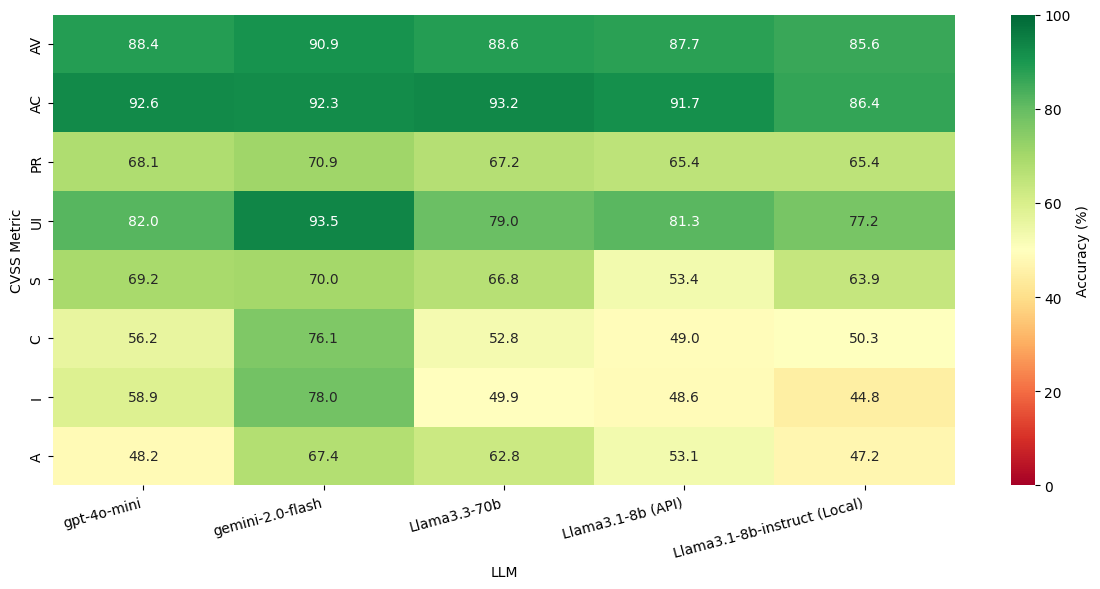


Detailed Accuracy Results:

gpt-4o-mini:
  AV: 88.4%
  AC: 92.6%
  PR: 68.1%
  UI: 82.0%
  S: 69.2%
  C: 56.2%
  I: 58.9%
  A: 48.2%

gemini-2.0-flash:
  AV: 90.9%
  AC: 92.3%
  PR: 70.9%
  UI: 93.5%
  S: 70.0%
  C: 76.1%
  I: 78.0%
  A: 67.4%

Llama3.3-70b:
  AV: 88.6%
  AC: 93.2%
  PR: 67.2%
  UI: 79.0%
  S: 66.8%
  C: 52.8%
  I: 49.9%
  A: 62.8%

Llama3.1-8b (API):
  AV: 87.7%
  AC: 91.7%
  PR: 65.4%
  UI: 81.3%
  S: 53.4%
  C: 49.0%
  I: 48.6%
  A: 53.1%

Llama3.1-8b-instruct (Local):
  AV: 85.6%
  AC: 86.4%
  PR: 65.4%
  UI: 77.2%
  S: 63.9%
  C: 50.3%
  I: 44.8%
  A: 47.2%


In [21]:
def parse_cvss_vector(vector):
    """Parse CVSS vector string into individual metrics."""
    # Remove CVSS:3.1/ prefix if present
    if vector.startswith('CVSS:3.1/'):
        vector = vector[9:]
    
    metrics = {}
    for metric in vector.split('/'):
        if ':' in metric:
            key, value = metric.split(':')
            metrics[key] = value
    return metrics

def compute_cvss_metric_accuracy(fname, models):
    """Compute accuracy for each CVSS metric across all models."""
    df = pd.read_csv(fname, sep='\t')
    
    # CVSS metric names in order
    metric_names = ['AV', 'AC', 'PR', 'UI', 'S', 'C', 'I', 'A']
    
    # Initialize results dictionary
    accuracy_results = {model: {metric: 0 for metric in metric_names} for model in models}
    total_count = len(df)  # Total number of rows/samples
    
    for idx, row in df.iterrows():
        gt_vector = row['GT'].upper()
        gt_metrics = parse_cvss_vector(gt_vector)
        
        for model in models:
            try:
                pred_vector = row[model].upper()
                pred_metrics = parse_cvss_vector(pred_vector)
                
                # Compare each metric
                for metric in metric_names:
                    if metric in gt_metrics and metric in pred_metrics:
                        if gt_metrics[metric] == pred_metrics[metric]:
                            accuracy_results[model][metric] += 1
            except Exception as e:
                print(f'Error processing row {idx+1}, model {model}: {e}')
                continue
    
    # Convert to percentages
    for model in models:
        for metric in metric_names:
            accuracy_results[model][metric] = (accuracy_results[model][metric] / total_count) * 100
    
    return accuracy_results, metric_names

def create_cvss_accuracy_heatmap(fname, models):
    """Create a heatmap showing CVSS metric accuracy across models."""
    accuracy_results, metric_names = compute_cvss_metric_accuracy(fname, models)
    
    # Convert to matrix format for heatmap (metrics as rows, models as columns)
    accuracy_matrix = []
    for metric in metric_names:
        row = [accuracy_results[model][metric] for model in models]
        accuracy_matrix.append(row)
    
    accuracy_matrix = np.array(accuracy_matrix)
    
    # Create the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(accuracy_matrix, 
                xticklabels=models,
                yticklabels=metric_names,
                annot=True, 
                fmt='.1f',
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.xlabel('LLM')
    plt.ylabel('CVSS Metric')
    plt.xticks(rotation=15, ha='right')  # Rotate x-axis labels diagonally
    plt.tight_layout()
    plt.show()
    
    return accuracy_results

# Define the models to compare
models_to_compare = ['gpt-4o-mini', 'gemini-2.0-flash',  'Llama3.3-70b', 'Llama3.1-8b (API)','Llama3.1-8b-instruct (Local)']

# Create the heatmap using the test file
accuracy_results = create_cvss_accuracy_heatmap('responses/combined-results.tsv', models_to_compare)

# Print detailed results
print("\nDetailed Accuracy Results:")
print("=" * 50)
for model in models_to_compare:
    print(f"\n{model}:")
    for metric in ['AV', 'AC', 'PR', 'UI', 'S', 'C', 'I', 'A']:
        print(f"  {metric}: {accuracy_results[model][metric]:.1f}%")